
#  Development of functions that apply saliency map on detected faces

In [49]:
import math
import cv2
import face_recognition
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as nd
from PIL import Image

In [50]:
image = face_recognition.load_image_file("../imgs/biden.jpg")
# image = face_recognition.load_image_file("../imgs/baby1.png")
# image = face_recognition.load_image_file("../imgs/1.jpg")

### Find all the faces in the image using the default HOG-based model.

In [51]:
# This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
# See also: find_faces_in_picture_cnn.py
face_locations = face_recognition.face_locations(image)

print("I found {} face(s) in this photograph.".format(len(face_locations)))

I found 1 face(s) in this photograph.


In [52]:
print(face_locations)

[(241, 740, 562, 419)]


In [53]:
for face_location in face_locations:
    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    cv2.rectangle(image, (left, top), ( right, bottom ), (255,0,0), 2)
    face_image = image[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    

A face is located at pixel location Top: 241, Left: 419, Bottom: 562, Right: 740


In [54]:
### Define required gaussian functions

In [55]:
def gaussian2D(x, y, sigma):
    '''create 2D Gaussian distribution'''
    return (1.0/(2*math.pi*(sigma**2)))*math.exp(-(1.0/(2*(sigma**2)))*(x**2 + y**2))


def mexican_hat(x, y, sigma1, sigma2):
    ''' @ gausain mixture(difference) creates mexican hat like shape '''
    return gaussian2D(x, y, sigma1) - gaussian2D(x, y, sigma2)


# TODO: basically a copy of the receptive field function - combine them!
def center_bias(func, mapsize):
    """make matrix from function"""
    g = np.zeros(mapsize)
    for xi in range(0, mapsize[0]):
        for yi in range(0,mapsize[1]):
            x = xi-mapsize[0]/2
            y = yi-mapsize[1]/2
            g[xi, yi] = func(x, y)
    # normalize to a height of one
    g = g / np.max(g)
    return g

In [56]:
def face_gaussian(top, bottom, right, left):
    sigma = (bottom - top)/4
    center = center_bias(lambda x, y: gaussian2D(x, y, sigma=sigma), (bottom-top, right-left))
    
    return center

1.0


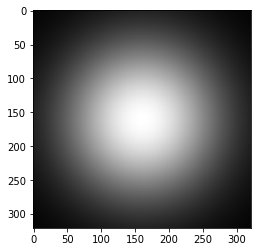

In [57]:
center = face_gaussian(top, bottom, right, left)
print(np.max(center))
plt.imshow(center, vmin=0, vmax=1, cmap='gray');

In [58]:
def apply_face_saliency(image, face_locations, blur=2):
    # TODO: add blur depending on the size of the picture
    '''
    Function creates a saliency map for face recognition feature, based on pre-detected face locations
    '''
    face_saliency = np.zeros_like(image[:,:,0], dtype='float64')

    for face_location in face_locations:
        # get all the face location and fit the gaussian into it
        top, right, bottom, left = face_location
        center = face_gaussian(top, bottom, right, left)

        # overwrtie the face are with gaussian
        face_saliency[top:bottom, left:right] = center
        
    # add blur
    saliency = nd.gaussian_filter(face_saliency, blur)
    
    return saliency

In [59]:
image = face_recognition.load_image_file("../imgs/1.jpg")
face_locations = face_recognition.face_locations(image)

face_saliency = apply_face_saliency(image, face_locations)

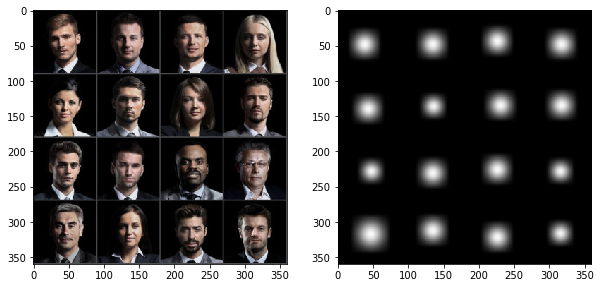

In [60]:
fig, ax =plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
ax[0].imshow(image);
ax[1].imshow(face_saliency, cmap='gray', vmin=0, vmax=1);